Map:   0%|          | 0/961 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]


--- Baseline ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40 (Baseline) - Loss: 5.0149


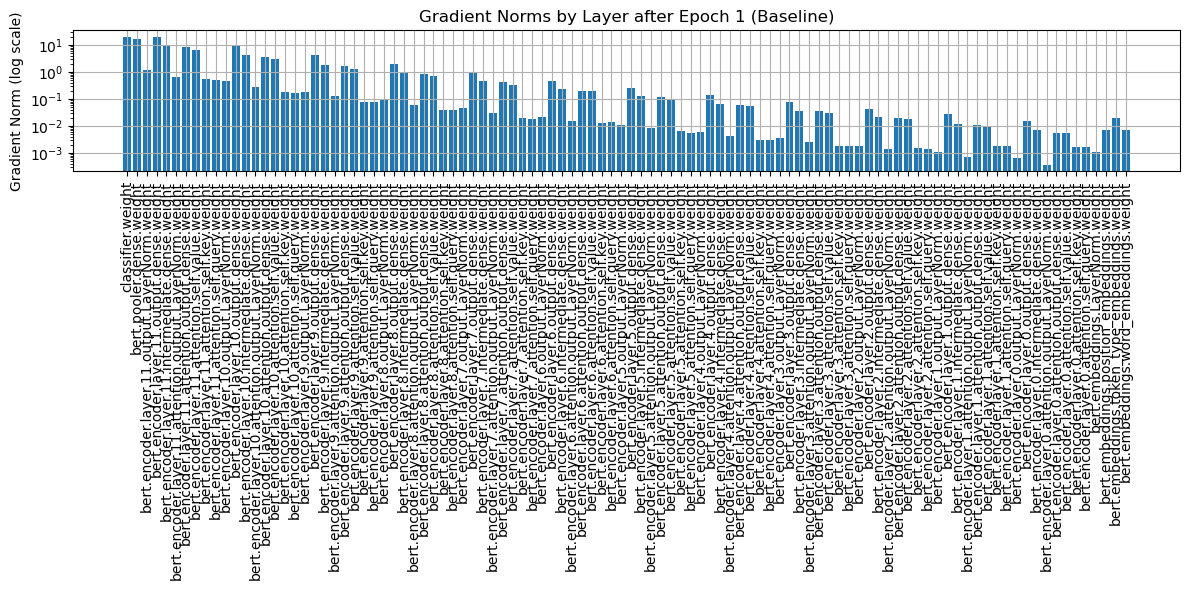

KeyboardInterrupt: 

In [107]:
import os
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
import matplotlib.pyplot as plt
import csv

# ===== Config =====
model_name = "emilyalsentzer/Bio_ClinicalBERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
max_length = 128
epochs = 40

# ===== Download DIAGNOSES_ICD.csv =====
url = "https://physionet.org/files/mimiciii-demo/1.4/DIAGNOSES_ICD.csv?download"
filename = "DIAGNOSES_ICD.csv"
if not os.path.exists(filename):
    with open(filename, "wb") as f:
        f.write(requests.get(url).content)

# ===== Prepare dataset =====
df = pd.read_csv(filename)
top_k = 100
top_codes = df["icd9_code"].value_counts().nlargest(top_k).index.tolist()
df = df[df["icd9_code"].isin(top_codes)].dropna(subset=["icd9_code"])
df["text"] = "Hospital admission with ICD-9 diagnosis code: " + df["icd9_code"].astype(str)
df["labels"] = df["icd9_code"].astype("category").cat.codes
label_names = df["icd9_code"].astype("category").cat.categories.tolist()
df = df[["text", "labels"]]

class_weights = compute_class_weight("balanced", classes=np.unique(df["labels"]), y=df["labels"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

dataset = Dataset.from_pandas(df)
splits = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset, eval_dataset = splits["train"], splits["test"]

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_length)

train_dataset = train_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
eval_dataset = eval_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

# ===== He Initialization =====
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# ===== Utility: Plot Gradient Norms =====
def plot_gradient_norms(gradients_dict, epoch, method_name):
    plt.figure(figsize=(12,6))
    plt.bar(gradients_dict.keys(), gradients_dict.values())
    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.ylabel("Gradient Norm (log scale)")
    plt.title(f"Gradient Norms by Layer after Epoch {epoch} ({method_name})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== Training Function =====
def train_model(model, optimizer, scheduler, train_loader, epochs, method_name):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        grads = {}

        def save_grad(name):
            def hook(grad):
                grads[name] = grad.norm().item()
            return hook
        for name, param in model.named_parameters():
            if param.requires_grad and "weight" in name:
                param.register_hook(save_grad(name))

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            logits = outputs.logits
            loss = F.cross_entropy(logits, batch["labels"], weight=class_weights)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} ({method_name}) - Loss: {total_loss/len(train_loader):.4f}")
        plot_gradient_norms(grads, epoch, method_name)

# ===== Evaluation Function =====
def evaluate_model(model, eval_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            preds = torch.argmax(logits, dim=1).cpu().tolist()
            labels = batch["labels"].cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)
    return acc, precision, recall, f1

# ===== Model Size Utility =====
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pt")
    size_mb = os.path.getsize("temp.pt") / (1024 * 1024)
    os.remove("temp.pt")
    return size_mb

# ===== Compression Methods =====
def baseline_model():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names)).to(device)
    model.apply(init_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)
    train_model(model, optimizer, scheduler, train_loader, epochs, "Baseline")
    return model

def lowrank_model(rank=8):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names)).to(device)
    model.apply(init_weights)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.data
            try:
                u, s, v = torch.svd_lowrank(weight, q=rank)
                module.weight.data.copy_((u @ torch.diag(s) @ v.t()).to(weight.device))
            except:
                pass
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)
    train_model(model, optimizer, scheduler, train_loader, epochs, "LoRA")
    return model

def pruning_model(amount=0.3):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names)).to(device)
    model.apply(init_weights)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)
    train_model(model, optimizer, scheduler, train_loader, epochs, "Pruning")
    return model

def distillation_model():
    teacher = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names)).to(device)
    teacher.eval()
    student = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names)).to(device)
    student.apply(init_weights)
    optimizer = torch.optim.AdamW(student.parameters(), lr=1e-5, weight_decay=0.01)
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)

    for epoch in range(1, epochs+1):
        student.train()
        total_loss = 0
        grads = {}

        def save_grad(name):
            def hook(grad):
                grads[name] = grad.norm().item()
            return hook
        for name, param in student.named_parameters():
            if param.requires_grad and "weight" in name:
                param.register_hook(save_grad(name))

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            student_logits = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            ce_loss = F.cross_entropy(student_logits, batch["labels"], weight=class_weights)
            kl_loss = F.kl_div(
                F.log_softmax(student_logits / 2.0, dim=-1),
                F.softmax(teacher_logits / 2.0, dim=-1),
                reduction="batchmean"
            ) * 4.0
            loss = 0.1 * ce_loss + 0.9 * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} (Distillation) - Loss: {total_loss/len(train_loader):.4f}")
        plot_gradient_norms(grads, epoch, "Distillation")

    return student

def fine_tune_model_on_cpu(model, lr=5e-5, epochs=20):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to("cpu")
            attention_mask = batch["attention_mask"].to("cpu")
            labels = batch["labels"].to("cpu")

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")
    return model

def quantization_model(lr=5e-5):
    # Load model on CPU
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names))
    model.to("cpu")

    # Fine-tune before quantization
    model = fine_tune_model_on_cpu(model, lr=lr, epochs=3)

    # Evaluate original model size
    size_before = get_model_size(model)

    # Apply dynamic quantization
    model_quantized = torch.quantization.quantize_dynamic(
        model,
        {torch.nn.Linear},
        dtype=torch.qint8
    )

    # Evaluate quantized model size
    size_after = get_model_size(model_quantized)
    print(f"Model size before quantization: {size_before:.2f} MB")
    print(f"Model size after quantization: {size_after:.2f} MB")

    # Define optimizer with learning rate (for potential logging)
    optimizer = torch.optim.SGD(model_quantized.parameters(), lr=lr)
    print(f"Optimizer initialized with learning rate: {lr}")

    # Evaluate on CPU
    model_quantized.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch["input_ids"].to("cpu")
            attention_mask = batch["attention_mask"].to("cpu")
            labels = batch["labels"].to("cpu")
            logits = model_quantized(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)
    print(f"Quantized Model Evaluation - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

    # Save final metrics to CSV
    with open("quantized_model_final_metrics.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Accuracy", "Precision", "Recall", "F1 Score"])
        writer.writerow([acc, prec, rec, f1])

    return model_quantized


# ===== Run All and Compare =====
def run_comparison():
    results = {}

    print("\n--- Baseline ---")
    baseline = baseline_model()
    acc, prec, rec, f1 = evaluate_model(baseline, eval_loader)
    size = get_model_size(baseline)
    results["baseline"] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "size_mb": size}

    print("\n--- LoRA Only ---")
    lora = lowrank_model()
    acc, prec, rec, f1 = evaluate_model(lora, eval_loader)
    size = get_model_size(lora)
    results["lora_only"] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "size_mb": size}

    print("\n--- Pruning Only ---")
    pruning = pruning_model()
    acc, prec, rec, f1 = evaluate_model(pruning, eval_loader)
    size = get_model_size(pruning)
    results["pruning_only"] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "size_mb": size}

    print("\n--- Distillation Only ---")
    distill = distillation_model()
    acc, prec, rec, f1 = evaluate_model(distill, eval_loader)
    size = get_model_size(distill)
    results["distillation_only"] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "size_mb": size}

    print("\n--- Quantization Only ---")
    quant = quantization_model()
    size = get_model_size(quant)
    results["quantization_only"] = {"acc": None, "prec": None, "rec": None, "f1": None, "size_mb": size}
    print(f"Quantization Only - Size: {size:.2f} MB (Eval skipped)")

    print("\n--- Summary ---")
    for name, metrics in results.items():
        print(f"{name}: Acc={metrics['acc']}, Prec={metrics['prec']}, Rec={metrics['rec']}, F1={metrics['f1']}, Size={metrics['size_mb']:.2f} MB")

if __name__ == "__main__":
    run_comparison()